# INDEX
* [Functions](#Functions)
* [Load datasets](#Load-datasets)
* [Configuration](#Configuration)
* [Preprocess training data](#Preprocess-training-data)
* [Train model](#Train-model)
* [Test model](#Test-model)
    * [Predict](#Predict)
    * [Translate predictions](#Translate-predictions)

# Prerequisites

In [ ]:
# Run this once to fetch and build the dataset:

import tensorflow_datasets as tfds

import datasets.off_category

builder = tfds.builder('off_category')
builder.download_and_prepare()

# Or run via command line (if tfds is in the path):
# !cd ../datasets && tfds build off_category

# Functions

In [1]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [2]:
# %load libtrain.py
import datetime
import functools
import json
import pathlib
import shutil
import tempfile
from typing import Dict, List

import dacite
import pandas as pd
import tensorflow as tf
from robotoff.taxonomy import Taxonomy
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras import callbacks
from tensorflow.python.ops import summary_ops_v2

import tensorflow_datasets as tfds

import settings

from category_classification.data_utils import load_dataset

from category_classification.models import (
    KerasPreprocessing,
    build_model,
    construct_preprocessing,
    to_serving_model,
)

from category_classification.config import Config

from utils.io import (
    copy_category_taxonomy,
    save_category_vocabulary,
    save_config,
    save_json,
)
from utils.metrics import evaluation_report


class TBCallback(callbacks.TensorBoard):
    """Get around a bug where you cannot use the TensorBoard callback with the StringLookup layers
    - https://github.com/tensorflow/tensorboard/issues/4530#issuecomment-783318292"""

    def _log_weights(self, epoch):
        with self._train_writer.as_default():
            with summary_ops_v2.always_record_summaries():
                for layer in self.model.layers:
                    for weight in layer.weights:
                        if hasattr(weight, "name"):
                            weight_name = weight.name.replace(":", "_")
                            summary_ops_v2.histogram(weight_name, weight, step=epoch)
                            if self.write_images:
                                self._log_weight_as_image(weight, weight_name, epoch)
                self._train_writer.flush()




def train(
    model: keras.Model,
    features: List[str],
    labels: str,
    save_dir: pathlib.Path,
    config: Config,
    category_vocab: List[str],
):
    print("Starting training...")
    temporary_log_dir = pathlib.Path(tempfile.mkdtemp())
    print("Temporary log directory: {}".format(temporary_log_dir))

    # for now, clear cache on each call to train(), to be safe
    cache_dir = pathlib.Path("tf_cache")
    shutil.rmtree(cache_dir, ignore_errors=True)
    cache_dir.mkdir()
    print("Cache directory: {}".format(cache_dir))

    batch_size = config.train_config.batch_size
    
    train = (
        load_dataset("off_category", "train", features, labels, category_vocab, batch_size)
        .cache(str(cache_dir / "train"))
    )
    val = (
        load_dataset("off_category", "val", features, labels, category_vocab, batch_size)
        .cache(str(cache_dir / "val"))
    )

    history=model.fit(
        train,
        epochs= config.train_config.epochs,
        validation_data=val,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                filepath=str(save_dir / "weights.{epoch:02d}-{val_loss:.4f}"),
                monitor="val_loss",
                save_best_only=True,
                save_format='tf',
            ),
            #TBCallback(log_dir=str(temporary_log_dir), histogram_freq=1),
            callbacks.EarlyStopping(monitor="val_loss", patience=4),
            callbacks.CSVLogger(str(save_dir / "training.log")),
            callbacks.History()
        ],
    )
    print("Training ended")
    return history

In [3]:
def create_model(config: Config, preprocess: KerasPreprocessing) -> keras.Model:
    model = build_model(config.model_config, preprocess)
    loss_fn = keras.losses.BinaryCrossentropy(
        label_smoothing=config.train_config.label_smoothing
    )
    optimizer = keras.optimizers.Adam(learning_rate=config.train_config.lr)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["binary_accuracy", "Precision", "Recall"],
    )
    return model

# Configuration

In [4]:
# load config json
import json
 
# Opening JSON file
with open('../config.json') as json_file:
    json_config = json.load(json_file)
json_config 

config=dacite.from_dict(Config, json_config)

model_config=config.model_config

output_dir:pathlib.Path = pathlib.Path("../models")
replicates = 1

output_dir.mkdir(parents=True, exist_ok=True)

# We add code for tracking, it's not used in the model
FEATURES = ["product_name", "ingredients_tags"]  #, "code"]
LABELS = "categories_tags"

# Preprocess training data

In [5]:
%%time

keras_preprocess = construct_preprocessing(
    model_config.category_min_count,
    model_config.ingredient_min_count,
    model_config.product_name_max_tokens,
    model_config.product_name_max_length,
    tfds.load("off_category", split="train")  # FIXME: not same shape as load_dataset
)

2022-05-12 19:57:20.641463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-12 19:57:20.641512: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-12 19:57:20.641541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alba): /proc/driver/nvidia/version does not exist
2022-05-12 19:57:20.642000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 1min 35s, sys: 43.9 s, total: 2min 19s
Wall time: 22.5 s


In [6]:
print(len(keras_preprocess.category_vocab))
print(len(keras_preprocess.product_name_preprocessing.get_vocabulary()))
print(len(keras_preprocess.ingredient_preprocessing.get_vocabulary()))

3969
93000
4223


# Train model

In [7]:
create_model(config, keras_preprocess).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
 ization)                                                                                         
                                                                                                  
 ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorization[0][0]'] 

In [8]:
%%time
import json

if replicates == 1:
    save_dirs = [output_dir]
else:
    save_dirs = [output_dir / str(i) for i in range(replicates)]

for i, save_dir in enumerate(save_dirs):
    model = create_model(config, keras_preprocess)
    save_dir.mkdir(exist_ok=True)
    config.train_config.start_datetime = str(datetime.datetime.utcnow())
    print(f"Starting training repeat {i}")

    save_config(config, save_dir)
    copy_category_taxonomy(settings.CATEGORY_TAXONOMY_PATH, save_dir)
    save_category_vocabulary(keras_preprocess.category_vocab, save_dir)
    # Get the dictionary containing each metric and the loss for each epoch
    history=train(
        model,
        FEATURES,
        LABELS,
        save_dir,
        config,
        keras_preprocess.category_vocab
    )

    config.train_config.end_datetime = str(datetime.datetime.utcnow())
    save_config(config, save_dir)
    config.train_config.start_datetime = None
    config.train_config.end_datetime = None

Starting training repeat 0
Starting training...
Temporary log directory: /tmp/tmpr0k_m3a1
Cache directory: tf_cache
Epoch 1/50


2022-05-12 20:01:40.216254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


   5465/Unknown - 430s 78ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2248 - recall: 0.0864

2022-05-12 20:08:51.016300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-12 20:09:06.395244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-12 20:09:08.066363: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so con

INFO:tensorflow:Assets written to: ../models/weights.01-0.0041/assets


INFO:tensorflow:Assets written to: ../models/weights.01-0.0041/assets


5465/5465 [==============================] - 451s 82ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2248 - recall: 0.0864 - val_loss: 0.0041 - val_binary_accuracy: 0.9990 - val_precision: 0.8444 - val_recall: 0.2421
Epoch 2/50


2022-05-12 20:09:11.171101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5465/5465 [==============================] - ETA: 0s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8172 - recall: 0.4172INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets


INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets


5465/5465 [==============================] - 449s 82ms/step - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8172 - recall: 0.4172 - val_loss: 0.0023 - val_binary_accuracy: 0.9994 - val_precision: 0.8868 - val_recall: 0.5567
Epoch 3/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0022 - binary_accuracy: 0.9994 - precision: 0.8466 - recall: 0.5962INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets


INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets


5465/5465 [==============================] - 452s 83ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - precision: 0.8466 - recall: 0.5962 - val_loss: 0.0018 - val_binary_accuracy: 0.9995 - val_precision: 0.8863 - val_recall: 0.6716
Epoch 4/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8580 - recall: 0.6655INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets


INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets


5465/5465 [==============================] - 437s 80ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8580 - recall: 0.6655 - val_loss: 0.0016 - val_binary_accuracy: 0.9995 - val_precision: 0.8885 - val_recall: 0.7129
Epoch 5/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8649 - recall: 0.6998INFO:tensorflow:Assets written to: ../models/weights.05-0.0015/assets


INFO:tensorflow:Assets written to: ../models/weights.05-0.0015/assets


5465/5465 [==============================] - 428s 78ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8649 - recall: 0.6998 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8909 - val_recall: 0.7345
Epoch 6/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8696 - recall: 0.7224INFO:tensorflow:Assets written to: ../models/weights.06-0.0015/assets


INFO:tensorflow:Assets written to: ../models/weights.06-0.0015/assets


5465/5465 [==============================] - 427s 78ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8696 - recall: 0.7224 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8888 - val_recall: 0.7514
Epoch 7/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8730 - recall: 0.7379INFO:tensorflow:Assets written to: ../models/weights.07-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.07-0.0014/assets


5465/5465 [==============================] - 441s 81ms/step - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8730 - recall: 0.7379 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8888 - val_recall: 0.7609
Epoch 8/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8759 - recall: 0.7495INFO:tensorflow:Assets written to: ../models/weights.08-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.08-0.0014/assets


5465/5465 [==============================] - 424s 78ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8759 - recall: 0.7495 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8912 - val_recall: 0.7651
Epoch 9/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8779 - recall: 0.7587INFO:tensorflow:Assets written to: ../models/weights.09-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.09-0.0014/assets


5465/5465 [==============================] - 414s 76ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8779 - recall: 0.7587 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8900 - val_recall: 0.7715
Epoch 10/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9995 - precision: 0.8799 - recall: 0.7658INFO:tensorflow:Assets written to: ../models/weights.10-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.10-0.0014/assets


5465/5465 [==============================] - 396s 72ms/step - loss: 0.0013 - binary_accuracy: 0.9995 - precision: 0.8799 - recall: 0.7658 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8905 - val_recall: 0.7755
Epoch 11/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7716INFO:tensorflow:Assets written to: ../models/weights.11-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.11-0.0014/assets


5465/5465 [==============================] - 391s 71ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7716 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8911 - val_recall: 0.7775
Epoch 12/50
5465/5465 [==============================] - 386s 71ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8827 - recall: 0.7770 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8893 - val_recall: 0.7807
Epoch 13/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8837 - recall: 0.7815INFO:tensorflow:Assets written to: ../models/weights.13-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.13-0.0014/assets


5465/5465 [==============================] - 392s 72ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8837 - recall: 0.7815 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8885 - val_recall: 0.7846
Epoch 14/50
5465/5465 [==============================] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8851 - recall: 0.7854INFO:tensorflow:Assets written to: ../models/weights.14-0.0014/assets


INFO:tensorflow:Assets written to: ../models/weights.14-0.0014/assets


5465/5465 [==============================] - 391s 72ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8851 - recall: 0.7854 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8876 - val_recall: 0.7876
Epoch 15/50
5465/5465 [==============================] - 385s 71ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7885 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8876 - val_recall: 0.7875
Epoch 16/50
5465/5465 [==============================] - 392s 72ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7918 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8881 - val_recall: 0.7896
Epoch 17/50
5465/5465 [==============================] - 389s 71ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8874 - recall: 0.7948 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8894 - val_recall: 0.7894
Epoch 18/50
5465/5465 [=============

In [9]:
log_data = pd.read_csv('../models/training.log', sep=',', engine='python')
log_data

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.998507,0.008176,0.224802,0.086442,0.999000,0.004127,0.844361,0.242067
1,1,0.999165,0.003276,0.817243,0.417224,0.999360,0.002274,0.886785,0.556723
2,2,0.999384,0.002240,0.846552,0.596250,0.999483,0.001776,0.886343,0.671612
3,3,0.999469,0.001867,0.857984,0.665515,0.999531,0.001604,0.888468,0.712851
4,4,0.999497,0.001686,0.864950,0.699834,0.999557,0.001512,0.890926,0.734524
5,5,0.999511,0.001571,0.869576,0.722363,0.999573,0.001459,0.888787,0.751426
6,6,0.999523,0.001493,0.872979,0.737891,0.999583,0.001426,0.888823,0.760851
7,7,0.999531,0.001432,0.875869,0.749505,0.999591,0.001407,0.891180,0.765078
8,8,0.999539,0.001385,0.877940,0.758678,0.999596,0.001394,0.889963,0.771494
9,9,0.999547,0.001348,0.879909,0.765814,0.999601,0.001382,0.890454,0.775480


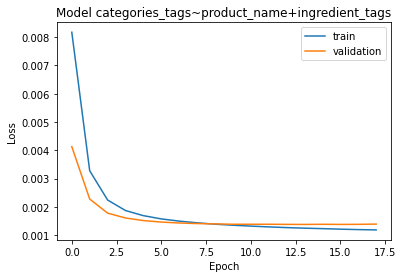

In [11]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

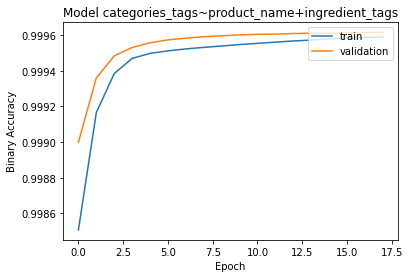

In [12]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['binary_accuracy'])
plt.plot(log_data['epoch'],log_data['val_binary_accuracy'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# Test model

In [8]:
# load saved model
model=keras.models.load_model('../models/base/saved_model')

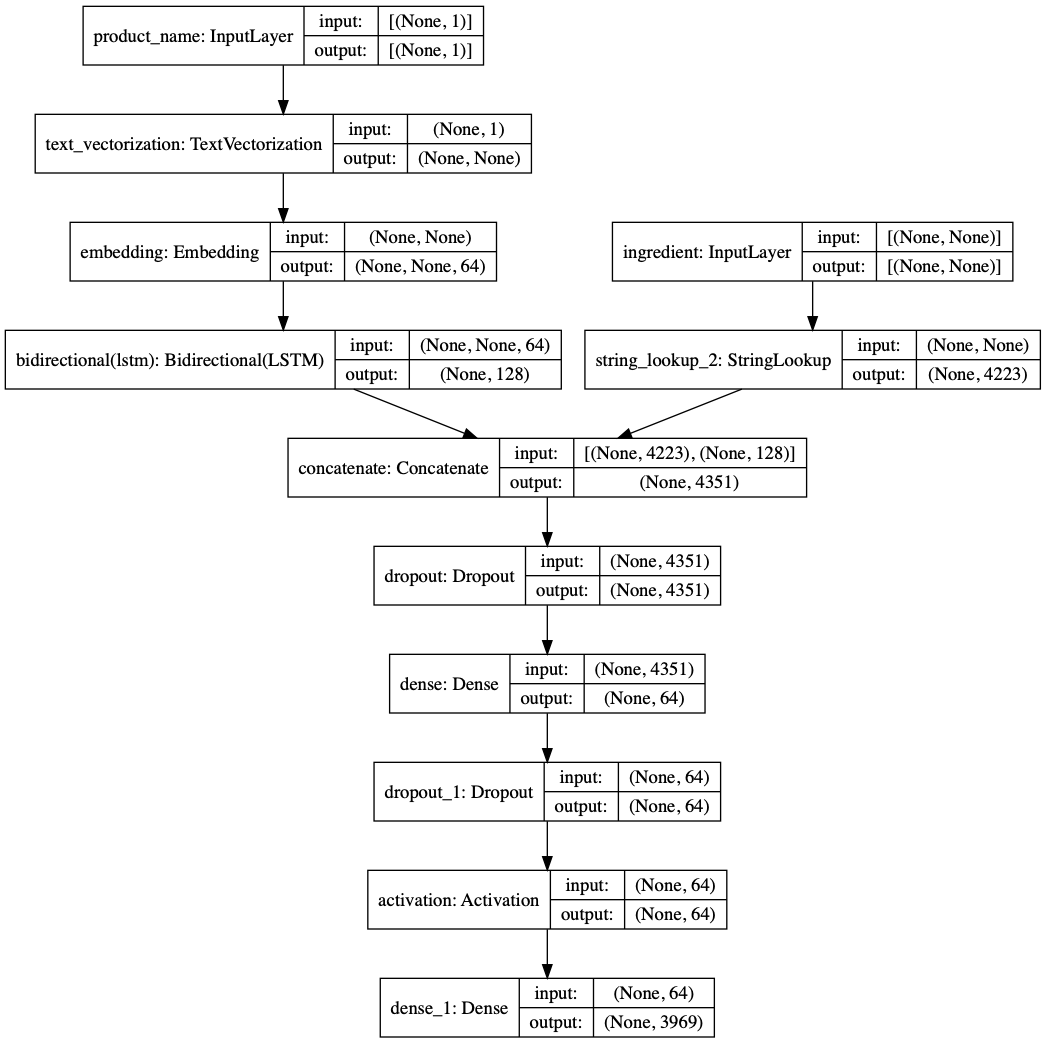

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
# create train, validation, test datasets
category_vocab = keras_preprocess.category_vocab
batch_size = config.train_config.batch_size

# Train & validation Dataset => investigate on characteristics of the source
valdata = create_tf_dataset("val", category_vocab, batch_size)
testdata = create_tf_dataset("test", category_vocab, batch_size)

In [12]:
# categories count
len(category_vocab)

3969

## Predict

In [13]:
%%time
y_pred_val = model.predict(valdata)

CPU times: user 1min 33s, sys: 19.8 s, total: 1min 52s
Wall time: 1min 19s


In [14]:
%%time
y_pred_test=model.predict(testdata)

CPU times: user 1min 33s, sys: 17.2 s, total: 1min 50s
Wall time: 1min 19s


In [15]:
y_pred_val.shape, y_pred_test.shape

((87433, 3969), (87433, 3969))

In [16]:
y_pred_val

array([[1.2839634e-05, 2.3829339e-10, 1.6613468e-09, ..., 1.5564917e-11,
        3.6129602e-10, 2.1100532e-12],
       [1.0495579e-01, 2.0508166e-09, 2.3943665e-09, ..., 1.3911613e-08,
        1.0217517e-08, 3.8321792e-07],
       [1.9471225e-05, 6.9090309e-14, 3.4578873e-15, ..., 1.7461139e-10,
        1.5341870e-09, 3.1657670e-11],
       ...,
       [3.8076937e-03, 1.6157297e-06, 6.6229441e-06, ..., 1.5495658e-06,
        8.5407564e-06, 3.0552114e-06],
       [1.3194382e-03, 1.6692168e-10, 3.1451508e-09, ..., 4.1883496e-14,
        4.0008695e-17, 5.4479357e-14],
       [1.3995171e-04, 4.6972501e-09, 6.7628605e-07, ..., 2.1551737e-16,
        4.0634079e-10, 5.0259212e-15]], dtype=float32)

## Translate predictions

In [17]:
import numpy as np

data=y_pred_val
NUMBER_OF_CATEGORIES = 4

values=np.partition(data,-NUMBER_OF_CATEGORIES) #top n probability values for each row
indices=np.argpartition(data,-NUMBER_OF_CATEGORIES) #top n probability values indices for each row

In [18]:
val=values[:,-NUMBER_OF_CATEGORIES:] # filter n first values for each row
ind=indices[:,-NUMBER_OF_CATEGORIES:] # filter n first values indices for each row

In [19]:
dfPredictions=(pd.DataFrame(ind).applymap(lambda x:category_vocab[x])+": "+pd.DataFrame(np.round(val*100,2)).astype(str)+" %").reset_index()

In [20]:
# make dictionary from validation dataframe to get code ande product_name
dict_val=val_ds[['code','product_name']].to_dict()

In [21]:
dfPredictions['product_name']=dfPredictions['index'].apply(lambda x:dict_val['product_name'][x])
dfPredictions['code']=dfPredictions['index'].apply(lambda x:dict_val['code'][x])
dfPredictions=dfPredictions.drop(columns=["index"])

In [22]:
dfPredictions

,0,1,2,3,product_name,code
0,en:groceries: 96.52 %,en:salts: 98.63 %,en:fleurs-de-sel: 97.92 %,en:unrefined-salts: 97.0 %,Fleur de sel,3183280018259
1,en:cereals-and-potatoes: 65.28 %,en:breakfast-cereals: 71.68 %,en:plant-based-foods: 85.16 %,en:plant-based-foods-and-beverages: 85.63 %,coco pops,8690504270591
2,en:plant-based-foods-and-beverages: 74.35 %,en:plant-based-beverages: 75.87 %,en:hot-beverages: 87.98 %,en:beverages: 97.96 %,"Thé épicé Dreaming camomille, lavande & valériane",8719179003652
3,en:plant-milks: 78.42 %,en:milk-substitute: 80.89 %,en:soy-milks: 86.2 %,en:legume-milks: 86.33 %,Soja Vanille Drink,4316268502504
4,en:confectioneries: 59.83 %,en:snacks: 94.23 %,en:sweet-snacks: 94.86 %,en:nougats: 97.1 %,Nougat au miel de Bretagne,3770011407224
...,...,...,...,...,...,...
87428,en:fermented-milk-products: 95.78 %,en:yogurts: 96.79 %,en:dairies: 98.91 %,en:fermented-foods: 97.39 %,Milk chocolate,0072431253607
87429,en:poultries: 91.34 %,en:duck-breasts: 95.89 %,en:ducks: 95.94 %,en:meats: 97.83 %,Yaourt framboise,3175241413616
87430,fr:charcuteries-diverses: 11.99 %,en:prepared-meats: 78.72 %,en:meats: 80.52 %,en:cured-sausages: 29.25 %,Magret de canard,2685323047758
87431,en:cheeses: 99.26 %,en:fermented-milk-products: 99.66 %,en:fermented-foods: 99.69 %,en:dairies: 99.88 %,La fine douce et équilibrée,3700133913709
